Malware Opcode Classification 

Authored by David Luong

Reference: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # for plotting model loss

#Import svm model
from sklearn import svm
#Import random forest model
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

#Import knn model
from sklearn.neighbors import KNeighborsClassifier

# Final evaluation of the model
from sklearn.metrics import accuracy_score

# fix random seed for reproducibility
tf.random.set_seed(7)

import os
import sys
import json

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Define Run Settings

In [2]:
# parameters
real_malware = 'WinWebSec' # OnLineGames, Renos, VBInject, WinWebSec, Zbot

use_harshit = 0 # 1 to use Harshit's fake samples, other to use Albert's
select_malware = 'vae_cnn_samples' # wgan_gp_samples, vae_cnn_samples, vae_dense_samples
select_vectorization = 'pos' # freq, pos
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts
max_sequence_length = 600

# LSTM
embedding_vector_length = 32

if real_malware == 'WinWebSec':
    fake_malware = 'wws'
    top_opcodes = 22
elif real_malware == 'OnLineGames':
    fake_malware = 'olgames'
    top_opcodes = 22
elif real_malware == 'Renos':
    fake_malware = 'renos'
    top_opcodes = 22
elif real_malware == 'VBInject':
    fake_malware = 'vbinject'
    top_opcodes = 25
elif real_malware == 'Zbot':
    fake_malware = 'zbot'
    top_opcodes = 20
else:
    print('!!!Malware not found!!!')


Define Helper Functions

In [3]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

Load Real and Fake Malware Files

In [4]:
# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# opening list of unique opcodes
if unique_opcodes == 0:
    my_fp = './code/visualize_explore/opcodes/'
    my_opcodes = open(my_fp + 'opcodes' + real_malware + '.txt','r')
    opcodes = my_opcodes.read()
    opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
    opcodes_into_list.remove('')
    # close opcodes file
    my_opcodes.close()
elif unique_opcodes == 1:
    my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
    opcodes_into_list = get_opcode_dict(real_malware,my_fp)

# real malware parameters
my_filepath = "../malware_data/" + real_malware +'/'
dir_list = os.listdir(my_filepath)

# process real malware
for fm in dir_list:
    # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
    print('Processing real malware' + my_filepath + fm)

    # opening the file in read mode
    my_file = open(my_filepath + fm, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")

    # remove '' from opcodes
    data_into_list.remove('')

    opcode_frequency = []
    if data_into_list:
            
        # create (opcode frequency, rank) tuple
        idx = 0
        for x in opcodes_into_list:
            count = countX(data_into_list, x)
            #print('{} has occurred {} times'.format(x,count))
            opcode_frequency.append((count,idx))
            idx+=1
        # print(sorted(opcode_frequency,reverse=True))

        # opcodes are indexed by overall frequency
        opcode_frequency = get_opcode_freq(opcode_frequency)

        # opcodes are indexed by opcodes_into_list position
        opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

        # add real malware to dataset
        dataset.append(opcode_position)
        dataset_names.append(fm)
        dataset_ind.append(0) # 0 is indicator for real malware
    else:
        # skip processing if malware file is empty
        print('------------> is empty ... skipping')

    # close file
    my_file.close()

nRealSamples = len(dataset)

# create fake malware dataset
if use_harshit == 1:
    my_fake_filepath = './code/fake_tests/fakeSamples/' + fake_malware # Harshit
    dir_list_fake = os.listdir(my_fake_filepath)

    for fake in dir_list_fake:
        # open the file
        my_fake_opcodes = open(my_fake_filepath + '/' + fake, "r")

        # reading the file
        data = my_fake_opcodes.read()

        # replacing end of line('/n') with ' ' and
        # splitting the text it further when '.' is seen.
        data_into_list = data.replace('\n', ' ').split(" ")

        # remove '' from opcodes
        data_into_list.remove('')

        opcode_frequency = []
        if data_into_list:
                
            # create (opcode frequency, rank) tuple
            idx = 0
            for x in opcodes_into_list:
                count = countX(data_into_list, x)
                #print('{} has occurred {} times'.format(x,count))
                opcode_frequency.append((count,idx))
                idx+=1
            # print(sorted(opcode_frequency,reverse=True))

            # opcodes are indexed by overall frequency
            opcode_frequency = get_opcode_freq(opcode_frequency)

            # opcodes are indexed by opcodes_into_list position
            opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

            # add real malware to dataset
            if select_vectorization == 'freq':
                dataset.append(opcode_frequency)
            elif select_vectorization == 'pos':
                dataset.append(opcode_position)

            dataset_ind.append(1)

        # close opcodes file
        my_fake_opcodes.close()

else: # self-generated malware
    
    # fake malware parameters
    my_fake_filepath = './code/fake_tests/' + select_malware + '/' + fake_malware + '/'
    dir_list = os.listdir(my_fake_filepath)

    # process fake malware
    for fm in dir_list:
        # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
        print('Processing fake malware' + my_fake_filepath + fm)

        # opening the file in read mode
        my_fake_file = open(my_fake_filepath + fm, "r")

        # reading the file
        data = my_fake_file.read()

        # replacing end of line('/n') with ' ' and
        # splitting the text it further when '.' is seen.
        data_into_list = data.replace('\n', ' ').split(" ")

        # remove '' from opcodes
        data_into_list.remove('')

        opcode_frequency = []
        if data_into_list:
                
            # create (opcode frequency, rank) tuple
            idx = 0
            for x in opcodes_into_list:
                count = countX(data_into_list, x)
                #print('{} has occurred {} times'.format(x,count))
                opcode_frequency.append((count,idx))
                idx+=1
            # print(sorted(opcode_frequency,reverse=True))

            # opcodes are indexed by overall frequency
            opcode_frequency = get_opcode_freq(opcode_frequency)

            # opcodes are indexed by opcodes_into_list position
            opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

            # add fake malware to dataset
            if select_vectorization == 'freq':
                dataset.append(opcode_frequency)
            elif select_vectorization == 'pos':
                dataset.append(opcode_position)

            dataset_names.append(fm)
            dataset_ind.append(1) # 1 is indicator for fake malware
        else:
            # skip processing if malware file is empty
            print('------------> is empty ... skipping')

        # close file
        my_fake_file.close()

nFakeSamples = len(dataset) - nRealSamples

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

Processing real malware../malware_data/WinWebSec/0009d99691e8eed99c7dd1500e07cda336d54260.asm.txt
Processing real malware../malware_data/WinWebSec/00113d9802cca3deba19cf9daa17f1c2269de2b8.asm.txt
Processing real malware../malware_data/WinWebSec/0036d720d8ff6c8f4860b5c69deba7c400e4d356.asm.txt
Processing real malware../malware_data/WinWebSec/0037c7716f1dc8e5c4e1f9a9f3e9d5aedb7a6979.asm.txt
Processing real malware../malware_data/WinWebSec/003824de7a82d2db9fc877c44ea93f76dd0e5ca9.asm.txt
Processing real malware../malware_data/WinWebSec/00427746e03afb4d3b28791a82315e52acf66a0b.asm.txt
Processing real malware../malware_data/WinWebSec/004bb59ba37917bfea49e6904f0551df7b3c719f.asm.txt
Processing real malware../malware_data/WinWebSec/005150c72b9cd08a62bc0d730e3593b4f160534a.asm.txt
Processing real malware../malware_data/WinWebSec/005231177f706856a0617a2c871d627ddedf54a7.asm.txt
Processing real malware../malware_data/WinWebSec/005e219370aaf892509b509b76cb082b36b16fcf.asm.txt
Processing fake malw

Visualize Real and Fake Malware Samples

Real Malware - WinWebSec


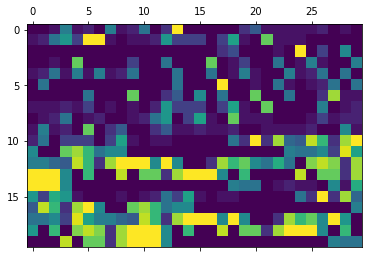

Fake Malware - WinWebSec


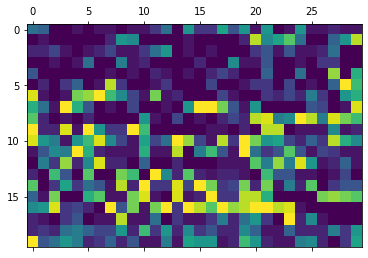

In [5]:
tmp = sequence.pad_sequences(X, maxlen=600, dtype='int32',
    padding='pre', truncating='pre', value=0.)

print('Real Malware - ' + real_malware)
plt.matshow(np.array(tmp[0]).reshape(20,30))
plt.show()

print('Fake Malware - ' + real_malware)
plt.matshow(np.array(tmp[-1]).reshape(20,30))
plt.show()

Define Training and Test Datasets

In [6]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

Define LSTM Model

In [7]:
# create LSTM model

model = Sequential()
model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
lstm_score = scores[1]*100
print("LSTM Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 32)           704       
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 54,005
Trainable params: 54,005
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6926 - accuracy: 0.5385 - val_loss: 0.6910 - val_accuracy: 0.4286
Epoch 2/10
1/1 [==============================] - 1s 524ms/step - loss: 0.6889 - accuracy: 0.5385 - val_loss: 0.6878 - val_accuracy: 0.4286
Epoch 3/10
1/1 [==================

Define Bidirectional LSTM Classifier

In [8]:
# create the bidirectional LSTM model

model = Sequential()
model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
bidirec_lstm_score = scores[1]*100
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 32)           704       
                                                                 
 bidirectional (Bidirectiona  (None, 200)              106400    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 107,305
Trainable params: 107,305
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.6940 - accuracy: 0.3846
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.6899 - accuracy: 0.5385
Epoch 3/10
1/1 [==============================] - 2

Define CNN LSTM Classifier

In [9]:
# create the LSTM+CNN model

model = Sequential()
model.add(Embedding(top_opcodes, embedding_vector_length, input_length=max_sequence_length))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=10, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
cnn_lstm_score = scores[1]*100
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 600, 32)           704       
                                                                 
 conv1d (Conv1D)             (None, 600, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 300, 32)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 57,109
Trainable params: 57,109
Non-trainable params: 0
__________________________________________________

Define SVM Classifer

In [10]:
#Create a svm Classifier
model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("SVM Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
svm_score = accuracy_score(y_test, y_pred)*100

SVM Accuracy: 71.43%


Define Random Forest Classifier

In [11]:
#Create a Random Forest Classifier
model = RandomForestClassifier(max_depth=2, random_state=0)

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("Random Forest Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
rf_score = accuracy_score(y_test, y_pred)*100

Random Forest Accuracy: 85.71%


Define k-Nearest Neighbor Classifier

In [12]:
#Create a k-NN Classifier
model = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training sets
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Final evaluation of the model
print("k-NN Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
knn_score = accuracy_score(y_test, y_pred)*100

k-NN Accuracy: 85.71%


Display All Classification Results

In [13]:
print('Classification on ' + str(nSamples) + ' ' + real_malware + ' Malware Samples (' + str(nRealSamples) + ' Real and ' + str(nFakeSamples) + ' Fake ' + select_malware + ')')
print('-------------------------------------------------')

print("SVM Score:", svm_score)
print("Random Forest Score:", rf_score)
print("k-Nearest Neighbor Score:", knn_score)
print("Standard LSTM Score:", lstm_score)
print("Bidirectional LSTM Score:", bidirec_lstm_score)
print("CNN LSTM Score:", cnn_lstm_score)

list_scores = [svm_score, rf_score, knn_score, lstm_score, bidirec_lstm_score, cnn_lstm_score]
print("=================================================")
print("Average Score:",sum(list_scores)/len(list_scores))
print("=================================================")

Classification on 20 WinWebSec Malware Samples (10 Real and 10 Fake vae_cnn_samples)
-------------------------------------------------
SVM Score: 71.42857142857143
Random Forest Score: 85.71428571428571
k-Nearest Neighbor Score: 85.71428571428571
Standard LSTM Score: 71.42857313156128
Bidirectional LSTM Score: 57.14285969734192
CNN LSTM Score: 42.85714328289032
Average Score: 69.04761982815606
